In [ ]:
!pip install torchmetrics
!pip install torchvision

import torchvision
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
from sklearn.metrics import r2_score

In [4]:
def ReadSplitDataFile(file_name):
  subject = {"segments": [], "id": -1, "Age": -1, "Height(cm)": -1, "Weight(kg)": -1, "Hemoglobin(g/L)": -1, "Gender": -1, "HR": -1}
  with open(file_name) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    k = 0

    red1 = []
    red2 = []
    ir1 = []
    ir2 = []
    for row in csv_reader:
      if k == 1:
        subject["id"] = int(row[4])
        subject["Age"] = int(row[5])
        subject["Height(cm)"] = float(row[6])
        subject["Weight(kg)"] = float(row[7])
        subject["Hemoglobin(g/L)"] = float(row[8])
        subject["HR"] = int(row[10])

        if row[9] == "male":
          subject["Gender"] = 1
        else:
          subject["Gender"] = 0

      if k > 0:
        red1.append(float(row[0]))
        red2.append(float(row[1]))
        ir1.append(float(row[2]))
        ir2.append(float(row[3]))

        if len(red1) == 100:
          subject["segments"].append([red1, red2, ir1, ir2])
          red1 = []
          red2 = []
          ir1 = []
          ir2 = []
      k += 1

# rationalize and preprocess //normalize and embed using pytorch embedding -> focus on the centeral question and which part of the signals is important(?) interpertable
# 1D CNN with 4 channels
# End use?
# advanced architecture, less features selections ?
# ????? keep the kernel small (GX BOOST)


  subject["segments"] = np.array(subject["segments"])
  return subject

In [5]:
subject = ReadSplitDataFile("data/1.csv")

In [6]:
subjects = []
for i in range(1, 59):
  subjects.append(ReadSplitDataFile("data/" + str(i) + ".csv"))

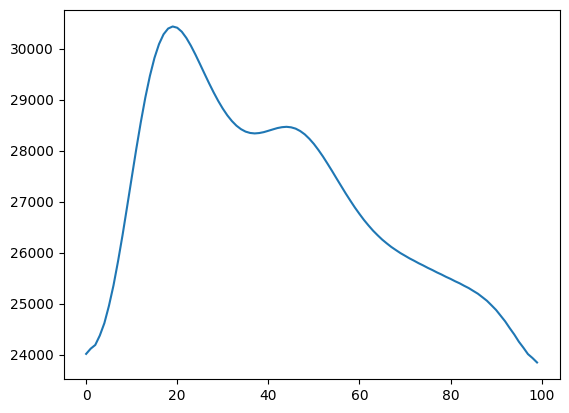

In [7]:
plt.plot(subjects[29]["segments"][1][3])
plt.show()

In [8]:
shuffled_subjects = subjects.copy()
random.shuffle(shuffled_subjects)
split = int(0.8*len(shuffled_subjects))
training_split, test_split = shuffled_subjects[:split], shuffled_subjects[split:len(shuffled_subjects)]

In [9]:
training_data = []

for subject in training_split:
  for segment in subject["segments"]:
    segment_data = {}
    segment_data["segment"] = segment
    segment_data["id"] = subject["id"]
    segment_data["Age"] = subject["Age"]
    segment_data["Height(cm)"] = subject["Height(cm)"]
    segment_data["Weight(kg)"] = subject["Weight(kg)"]
    segment_data["Hemoglobin(g/L)"] = subject["Hemoglobin(g/L)"]
    segment_data["Gender"] = subject["Gender"]
    segment_data["HR"] = subject["HR"]
    training_data.append(segment_data)

random.shuffle(training_data)

In [10]:
test_data = []

for subject in test_split:
  for segment in subject["segments"]:
    segment_data = {}
    segment_data["segment"] = segment
    segment_data["id"] = subject["id"]
    segment_data["Age"] = subject["Age"]
    segment_data["Height(cm)"] = subject["Height(cm)"]
    segment_data["Weight(kg)"] = subject["Weight(kg)"]
    segment_data["Hemoglobin(g/L)"] = subject["Hemoglobin(g/L)"]
    segment_data["Gender"] = subject["Gender"]
    segment_data["HR"] = subject["HR"]
    test_data.append(segment_data)

random.shuffle(test_data)

In [11]:
print(len(training_data))
print(len(test_data))

3551
937


In [12]:
train_segments = []
train_meta_data = []
train_targets = []
for segment in training_data:
  train_segments.append(segment["segment"])
  train_targets.append(segment["Hemoglobin(g/L)"])
  train_meta_data.append([segment["Age"], segment["Height(cm)"], segment["Weight(kg)"], segment["Gender"], segment["HR"]])

train_segments = np.array(train_segments)
train_targets = np.array(train_targets)
train_meta_data = np.array(train_meta_data)

In [13]:
train_targets = train_targets.reshape(len(train_targets), 1)
print("Target shape:", train_targets.shape)

print("Segment shape:", train_segments.shape)
print("Meta data shape:", train_meta_data.shape)

Target shape: (3551, 1)
Segment shape: (3551, 4, 100)
Meta data shape: (3551, 5)


In [20]:
class RegressionCNN(nn.Module):
  def __init__(self, meta_data_size=5):
    super(RegressionCNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size = 1, padding = 1)
    self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
    self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(64 * 1 * 25 + meta_data_size, 128)
    self.fc2 = nn.Linear(128, 1)


  def forward(self, x, meta_data):
    x = self.conv1(x)
    x = torch.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = torch.relu(x)
    x = self.pool2(x)

    x = self.flatten(x)

    x = torch.cat((x, meta_data), dim=1)

    x = self.fc1(x)
    x = torch.relu(x)
    x = self.fc2(x)

    return x


In [18]:
model = RegressionCNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
num_epochs = 500
batch_size = 16

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0.0

  for k in range(0, len(train_segments), batch_size):
    batch_data = train_segments[k:k+batch_size]
    batch_targets = train_targets[k:k+batch_size]
    batch_data = torch.tensor(batch_data, dtype = torch.float32).unsqueeze(1)
    batch_meta_data = torch.tensor(train_meta_data[k:k+batch_size], dtype = torch.float32)
    batch_targets = torch.tensor(batch_targets, dtype = torch.float32)

    optimizer.zero_grad()
    outputs = model(batch_data, batch_meta_data)
    loss = criterion(outputs, batch_targets)
    epoch_loss += loss.item() * batch_data.size(0)
    loss.backward()
    optimizer.step()

  avg_epoch_loss = epoch_loss / len(train_segments)
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')


Epoch [1/500], Loss: 347.9462
Epoch [2/500], Loss: 323.5555
Epoch [3/500], Loss: 311.0311
Epoch [4/500], Loss: 303.2209
Epoch [5/500], Loss: 304.8245
Epoch [6/500], Loss: 283.0580
Epoch [7/500], Loss: 266.1021
Epoch [8/500], Loss: 268.3785
Epoch [9/500], Loss: 240.7366
Epoch [10/500], Loss: 221.5573
Epoch [11/500], Loss: 211.6333
Epoch [12/500], Loss: 222.1721
Epoch [13/500], Loss: 196.7795
Epoch [14/500], Loss: 200.6389
Epoch [15/500], Loss: 396.9358
Epoch [16/500], Loss: 175.6718
Epoch [17/500], Loss: 167.8209
Epoch [18/500], Loss: 164.2274
Epoch [19/500], Loss: 163.4713
Epoch [20/500], Loss: 160.5545
Epoch [21/500], Loss: 155.7557
Epoch [22/500], Loss: 153.0732
Epoch [23/500], Loss: 150.6828
Epoch [24/500], Loss: 149.2700
Epoch [25/500], Loss: 148.2857
Epoch [26/500], Loss: 144.3617
Epoch [27/500], Loss: 141.0335
Epoch [28/500], Loss: 139.6582
Epoch [29/500], Loss: 138.6962
Epoch [30/500], Loss: 138.2746
Epoch [31/500], Loss: 137.6720
Epoch [32/500], Loss: 137.5297
Epoch [33/500], L

In [ ]:
test_segments = []
test_targets = []
test_meta_data = []
for segment in test_data:
  test_segments.append(segment["segment"])
  test_targets.append(segment["Hemoglobin(g/L)"])
  test_meta_data.append([segment["Age"], segment["Height(cm)"], segment["Weight(kg)"], segment["Gender"], segment["HR"]])


test_segments = np.array(test_segments)
test_targets = np.array(test_targets)
test_meta_data = np.array(test_meta_data)

test_targets = test_targets.reshape(len(test_targets), 1)
print("Test target shape:", test_targets.shape)

print("Test segment shape:", test_segments.shape)
print("Test meta data shape:", test_meta_data.shape)

Test target shape: (933, 1)
Test segment shape: (933, 4, 100)
Test meta data shape: (933, 5)


In [ ]:
test_segments = torch.tensor(test_segments, dtype=torch.float32)
test_targets = torch.tensor(test_targets, dtype=torch.float32)
test_meta_data = torch.tensor(test_meta_data, dtype=torch.float32)

test_segments = test_segments.unsqueeze(1)

# Set the model to evaluation mode (turn off dropout, batchnorm, etc.)
model.eval()

# Perform inference (no gradient calculation needed)
with torch.no_grad():  # No need to track gradients during evaluation
    predictions = model(test_segments, test_meta_data)  # Model output (predicted values)
    loss = criterion(predictions, test_targets)  # Calculate loss (MSE in this case

# Convert the predictions and targets to numpy arrays for R^2 calculation
predictions_np = predictions.numpy().flatten()  # Flatten to 1D array
targets_np = test_targets.numpy().flatten()  # Flatten to 1D array

In [ ]:
print(loss)

tensor(267.5075)


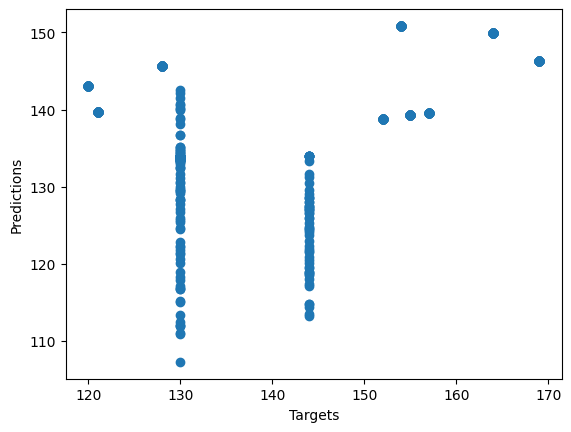

In [ ]:
plt.plot(targets_np, predictions_np, 'o')
plt.xlabel("Targets")
plt.ylabel("Predictions")
plt.show()

In [ ]:
printed_vals = []
for val in targets_np:
  if val not in printed_vals:
    printed_vals.append(val)
    print(val)

120.0
144.0
121.0
152.0
128.0
130.0
169.0
154.0
164.0
155.0
157.0


In [ ]:
print(predictions_np)

[101.933525  87.41567  169.81857  118.138695 191.4277   119.182526
 138.15005  185.30066  107.19416  185.09705   86.13876  120.310875
 128.01788  285.57947   96.83604  155.32379  152.40146  121.0017
 124.25556  126.006966 189.05649  223.89304  104.488335 123.71291
 152.05371  276.73837  151.10663  170.00392  104.83474  120.11901
  86.24932  289.32462  122.62064  122.78719  129.38666  140.46687
 276.5175   161.78616  108.20559  122.65006  181.42368  278.9539
 253.09814  132.5451    86.36058  160.65903  105.478325 144.31525
 140.36877  132.25285  111.824615 113.90966  119.53109  109.57334
  94.72149  265.34622  116.2564   122.61263  173.28491  110.73529
 261.87177  153.50421  118.34615  132.40927  144.4628   145.40808
  89.12655  153.43185   96.86874   89.36971  115.49903  279.65247
  94.24804   96.04331  140.69403  216.36075  139.65598  286.09814
 173.59166  119.8953   139.55357  257.39246   86.77727  142.1323
  94.08718  149.50172  147.13147  124.48063  112.38916  103.85522
 109.144066